In [1]:
import numpy as np
import matplotlib
%matplotlib widget
import matplotlib.pyplot as plt
import scipy
import os
from helper import Data_reduction

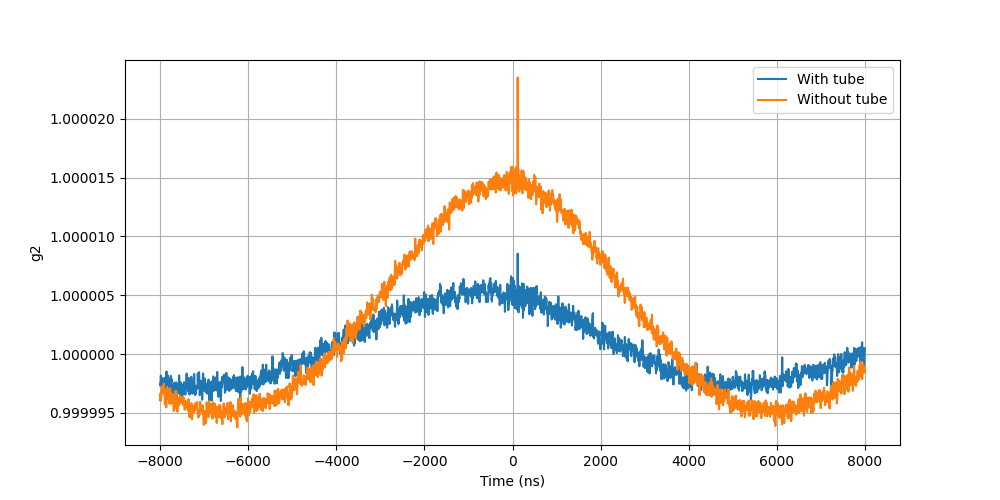

In [2]:
Tube = Data_reduction('D:/20240614_10x40', 'reduced_data/20240614_10x40')
Tube.get_average_g2()
NoTube = Data_reduction('D:/20240614_10x40_wotube', 'reduced_data/20240614_10x40_wotube')
NoTube.get_average_g2()
plt.close('all')
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(Tube.time_arr*1e9, Tube.av_g2, label='With tube')
ax.plot(NoTube.time_arr*1e9, NoTube.av_g2, label='Without tube')
ax.set(xlabel='Time (ns)', ylabel='g2')
ax.ticklabel_format(useOffset=False)
ax.grid()
ax.legend()

## withtube

[80, 83]


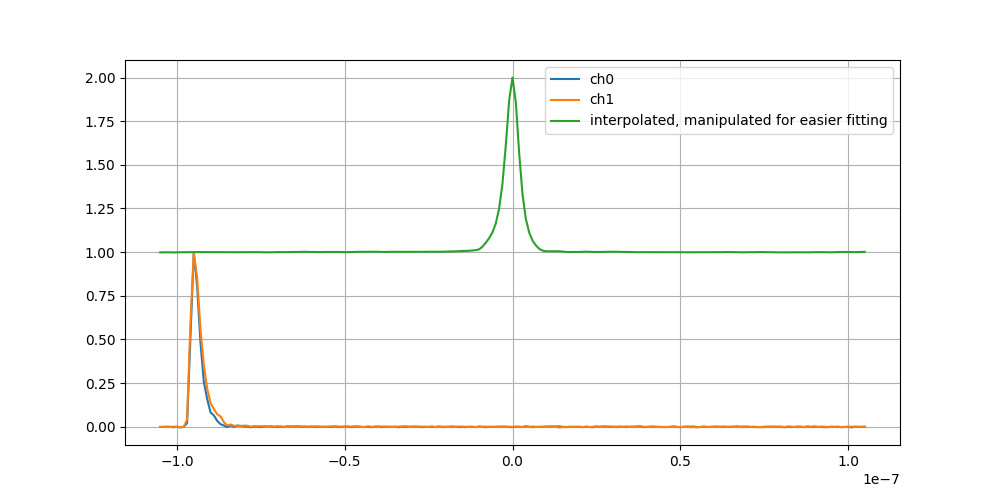

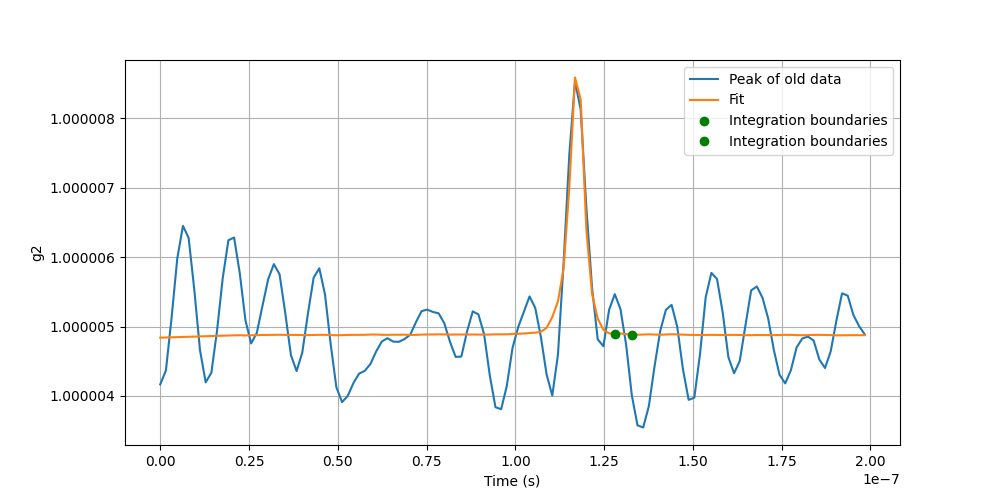

In [15]:
from threading import local


fit_mask = np.logical_and(Tube.time_arr > 0, Tube.time_arr < 200e-9) # Mask for fitting the peak

# Load the shape of the single photon pulses from calib files
shape0 =  np.loadtxt('D:\\20240614_10x40\\ch0\\calib.shape1')
shape1 = np.loadtxt('D:\\20240614_10x40\\ch1\\calib.shape1')
# Correlation and normalisation/shifting for easier fitting
pulse = scipy.signal.correlate(shape0[:,1], shape1[:,1], mode='same')
pulse= pulse/np.max(pulse) +1
x = np.arange(0,211)*1e-9
x = x - x[np.argmax(pulse)]

# Interpolation, and fitting
y = scipy.interpolate.interp1d(x, pulse, fill_value='extrapolate', kind='linear')
def fit_func(x, a, b, c, d):
    return a*y(b*x - c) +d
p0 = [3e-6, 1, 100e-9, 5e-6]
popt, pcov = scipy.optimize.curve_fit(fit_func, Tube.time_arr[fit_mask], Tube.av_g2[fit_mask], p0=p0)

# Find the local minima next to the peak as integration boundaries
peak_pos = Tube.time_arr[np.argmax(Tube.av_g2)] 
local_minima = scipy.signal.argrelmin(fit_func(Tube.time_arr[fit_mask], *popt))[0]
minima_threshold = 0.2e-7
# only keep minima that are close to the peak, adjust threshold if necessary
local_minima = [m for m in local_minima if (peak_pos - minima_threshold < Tube.time_arr[fit_mask][m] < peak_pos + minima_threshold)]

# Do the integration
# lower_bound = t[fit_mask][local_minima[0]]
# upper_bound = t[fit_mask][local_minima[1]]
# integral, error_estimate = scipy.integrate.quad(fit_func, lower_bound, upper_bound, args=tuple(popt))
# print(integral)

print(local_minima)
# Plotting
fig,ax = plt.subplots(figsize=(10, 5))
ax.plot(x, shape0[:,1], label='ch0')
ax.plot(x, shape1[:,1], label='ch1')
ax.plot(x, y(x), label='interpolated, manipulated for easier fitting')
ax.grid()
ax.legend()
fig,ax = plt.subplots(figsize=(10, 5))
ax.plot(Tube.time_arr[fit_mask], Tube.av_g2[fit_mask], label='Peak of old data')
ax.plot(Tube.time_arr[fit_mask], fit_func(Tube.time_arr[fit_mask], *popt), label='Fit')
for i in local_minima:
    ax.plot(Tube.time_arr[fit_mask][i], fit_func(Tube.time_arr[fit_mask][i], *popt), 'go', label='Integration boundaries')
ax.set(xlabel='Time (s)', ylabel='g2')
ax.ticklabel_format(useOffset=False)
ax.grid() 
ax.legend()